In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu110

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
from gluoncv.utils.metrics.segmentation import SegmentationMetric
from mxnet.gluon.data.vision import transforms
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from importlib import reload
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics
import time
from tqdm.notebook import tqdm

# MXNet ND-Arrays with Numpy notation
#mx.npx.set_np()

# Local Libraries
import pedestrian
import utils

# GPU mode
ctx = mx.gpu()

In [3]:
# Penn-Fudan Pedestrian Dataset
# https://www.cis.upenn.edu/~jshi/ped_html/

reload(pedestrian)

if not os.path.exists(pedestrian.PEDESTRIAN_FILE):
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

pedestrian_path = os.getcwd()

# Dataset for evaluation (improved visualizations)
pedestrian_dataset_evaluation = pedestrian.PedestrianDataset(
    pedestrian_path,
    is_segmentation_task=True,
    invert_masks=True)

# Dataset for training (includes pre-processing)
pedestrian_dataset_training = pedestrian.PedestrianDataset(
    pedestrian_path,
    is_segmentation_task=True,
    invert_masks=False)

# Further pre-processing
image_size = 480

input_transform = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

output_transform = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size)
])

transform = lambda data, output: (input_transform(data), output_transform(output))

p_train = pedestrian_dataset_training.transform(transform)

Read 170 images with 423 pedestrians
Read 170 images with 423 pedestrians


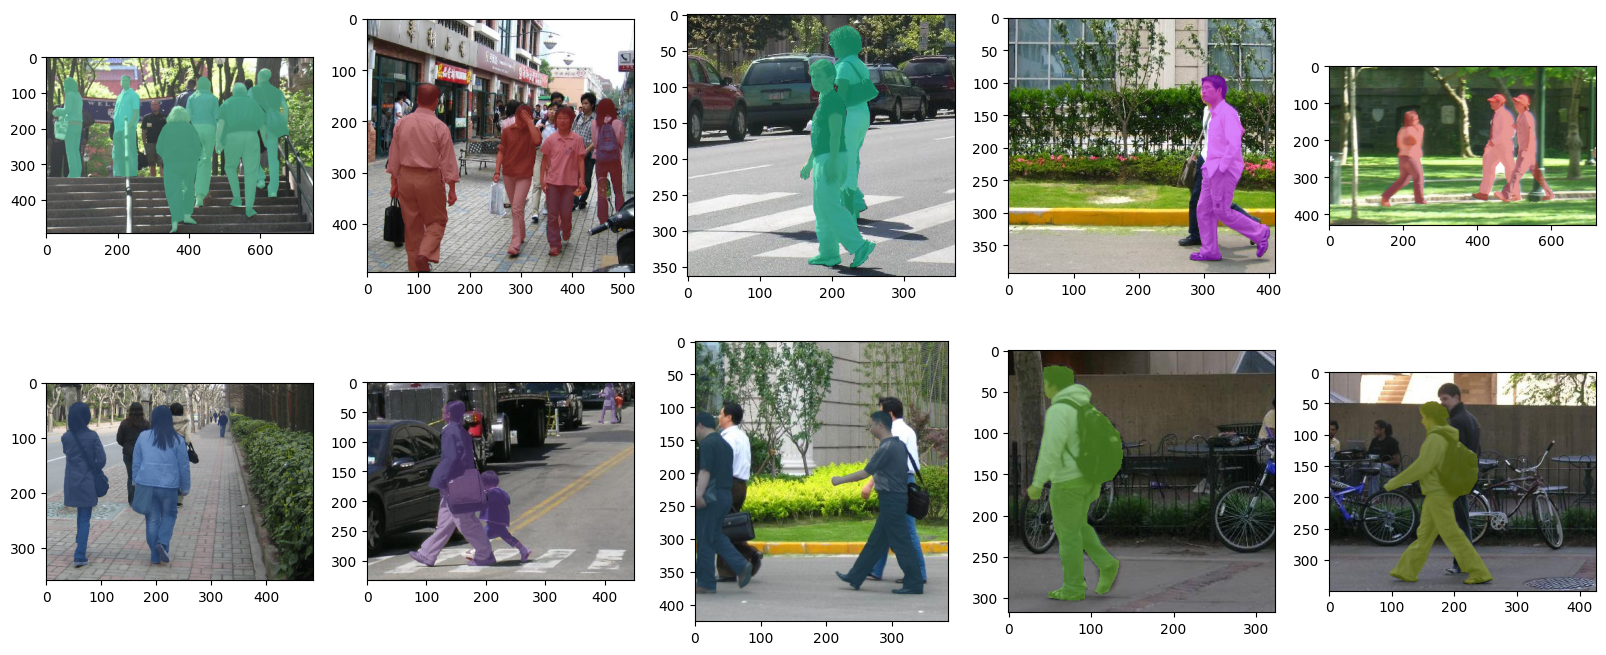

In [4]:
# Display 10 images from the dataset
# 5 x 2 grid
num_images_to_plot = 10
num_columns = 5

fig = plt.figure(figsize=(20, 8))

images_plotted = 0

number_pedestrians = 0

for (X, y) in pedestrian_dataset_evaluation:
        
    # Format inputs
    image = X
    gt_mask = y

    axes = fig.add_subplot(2, 5, images_plotted + 1)
    masked_image = gcv.utils.viz.plot_mask(image, gt_mask)
    axes.imshow(masked_image)

    images_plotted += 1

    if images_plotted == num_images_to_plot:
        # We are done
        break


In [5]:
test_image, test_gt_mask = pedestrian_dataset_evaluation[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

[20:33:29] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


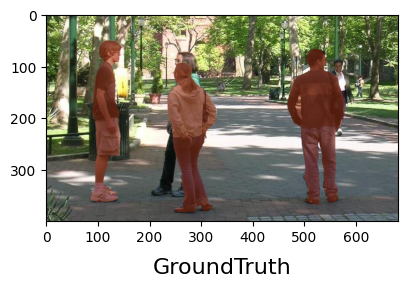

In [6]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.imshow(masked_test_image)

## Training from scratch

In [9]:
# Context List (for distributed training)
ctx_list = [mx.gpu()]

# Model
deeplab_ts = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)
print(deeplab_ts.auxlayer)
deeplab_ts.auxlayer = gcv.model_zoo.fcn._FCNHead(1024, 1)
print(deeplab_ts.auxlayer)
deeplab_ts.initialize(mx.init.MSRAPrelu(), force_reinit=True, ctx=ctx)

model_filename_ts = "deeplab_resnet101_coco_ts.params"

# Define Loss Function (Binary, cats vs dogs)
criterion = MixSoftmaxCrossEntropyLoss()

# Define Optimizer and Hyper Parameters
lr_scheduler = gcv.utils.LRScheduler(
    mode='poly',
    base_lr=0.001,
    nepochs=50, 
    iters_per_epoch=len(p_train), 
    power=0.9)

kv_ts = mx.kv.create('local')

optimizer = mx.gluon.Trainer(deeplab_ts.collect_params(), 'sgd',
    {
        'lr_scheduler': lr_scheduler,
        'wd':0.0001,
        'momentum': 0.9,
        'multi_precision': True
    },
    kvstore = kv_ts)

_FCNHead(
  (block): HybridSequential(
    (0): Conv2D(1024 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=256)
    (2): Activation(relu)
    (3): Dropout(p = 0.1, axes=())
    (4): Conv2D(256 -> 21, kernel_size=(1, 1), stride=(1, 1))
  )
)
_FCNHead(
  (block): HybridSequential(
    (0): Conv2D(1024 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=256)
    (2): Activation(relu)
    (3): Dropout(p = 0.1, axes=())
    (4): Conv2D(256 -> 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [11]:
import seg_model
reload(seg_model)

# Epochs & Batch Size
epochs = 10
batch_size = 2

# Training Loop
training_loss, training_px_acc, training_miou, validation_loss, validation_px_acc, validation_miou = seg_model.training_loop(
    deeplab_ts,
    criterion,
    optimizer,
    epochs,
    batch_size,
    p_train,
    p_train,
    model_filename_ts,
    ctx_list)

  0%|          | 0/10 [00:00<?, ?it/s]

E:    1, TrL: 1.083639, VL: 1.590850 --- Updating saved model
E:    2, TrL: 0.715125, VL: 0.813788 --- Updating saved model
E:    3, TrL: 0.649353, VL: 0.596005 --- Updating saved model
E:    4, TrL: 0.591213, VL: 0.880640
E:    5, TrL: 0.556915, VL: 0.790693
E:    6, TrL: 0.533122, VL: 1.058635
E:    7, TrL: 0.529028, VL: 1.129909
E:    8, TrL: 0.501504, VL: 0.985806
E:    9, TrL: 0.500730, VL: 0.954085
E:   10, TrL: 0.476057, VL: 1.107756


/home/andreto/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

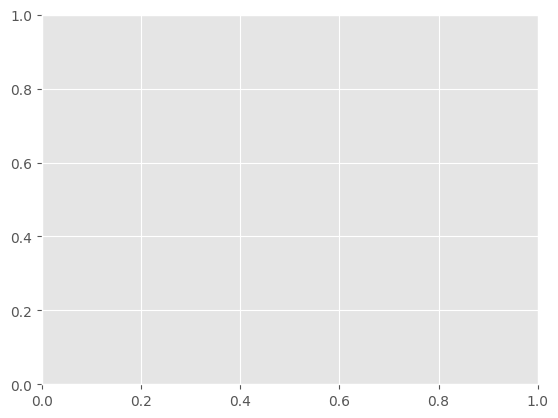

In [12]:
# plot the losses
fig = plt.figure
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [14]:
# Re-loading dataset, pre-processed for evaluation
reload(pedestrian)

# Load best model trained
deeplab_ts.load_parameters(model_filename_ts, ctx=ctx)

segmentation_metrics = SegmentationMetric(nclass=1)

for (X, y) in tqdm(pedestrian_dataset):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ts.predict(transformed_image)
    filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
    
    segmentation_metrics.update(gt_mask, filtered_output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

Read 170 images with 423 pedestrians


  0%|          | 0/170 [00:00<?, ?it/s]

[22:45:44] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[22:45:52] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[22:46:02] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[22:46:10] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[22:46:20] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running perf

PixAcc:  0.8276310335319587
mIoU  :  0.8276310335319587


(1, 21, 399, 683) (1, 399, 683)


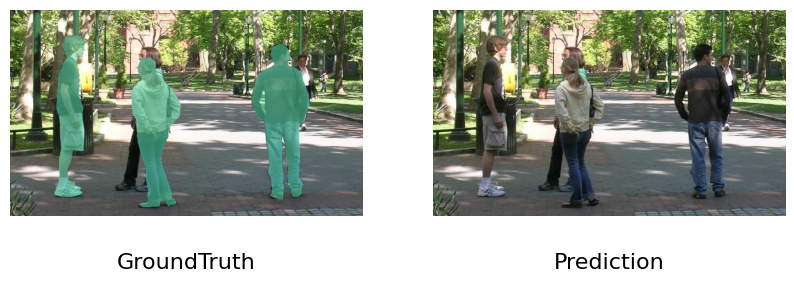

In [15]:
# Qualitative Evaluation
test_image, test_gt_mask = pedestrian_dataset[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_ts.predict(transformed_image)
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
print(output.shape, filtered_output.shape)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output)

## Pre-Trained Model

In [16]:
# ResNet50 from Model Zoo (This downloads v1d)
# No Pre-trained weights (training from scratch)
deeplab_pt = gcv.model_zoo.get_model("deeplab_resnet101_coco", pretrained=True, ctx=ctx)

In [17]:
# Re-loading dataset, pre-processed for evaluation
reload(pedestrian)

segmentation_metrics = SegmentationMetric(nclass=1)

for (X, y) in tqdm(pedestrian_dataset_evaluation):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_pt.predict(transformed_image)
    filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
    
    segmentation_metrics.update(gt_mask, filtered_output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/170 [00:00<?, ?it/s]

PixAcc:  0.4677596950405365
mIoU  :  0.564584135590197


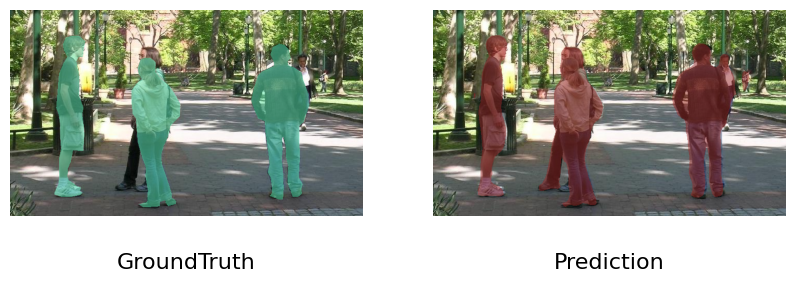

In [18]:
# Qualitative Evaluation
test_image, test_gt_mask = pedestrian_dataset_evaluation[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_pt.predict(transformed_image)
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Transfer Learning

In [19]:
# Context List (for distributed training)
ctx_list = [mx.gpu()]

# Model
deeplab_tl = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx_list)

# Freeze Layers (keeping track of the updated parameters)
updated_params = []
for param in deeplab_tl.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"
        updated_params += [param.name]

# Replace the last layers
deeplab_tl.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_tl.head.initialize(ctx=ctx_list)
deeplab_tl.head.collect_params().setattr('lr_mult', 10)
deeplab_tl.auxlayer = gcv.model_zoo.fcn._FCNHead(1024, 2)
deeplab_tl.auxlayer.initialize(ctx=ctx_list)
deeplab_tl.auxlayer.collect_params().setattr('lr_mult', 10)

model_filename_tl = "deeplab_resnet101_coco_tl.params"

# Define Loss Function (Binary, cats vs dogs)
criterion = MixSoftmaxCrossEntropyLoss()

# Define Optimizer and Hyper Parameters
lr_scheduler = gcv.utils.LRScheduler(
    mode='poly',
    base_lr=0.001,
    nepochs=50, 
    iters_per_epoch=len(p_train), 
    power=0.9)

kv_tl = mx.kv.create('local')

optimizer = mx.gluon.Trainer(deeplab_tl.collect_params(), 'sgd',
    {
        'lr_scheduler': lr_scheduler,
        'wd':0.0001,
        'momentum': 0.9,
        'multi_precision': True
    },
    kvstore = kv_tl)

In [ ]:
import seg_model
reload(seg_model)

# Epochs & Batch Size
epochs = 10
batch_size = 2

# Training Loop
training_loss, training_px_acc, training_miou, validation_loss, validation_px_acc, validation_miou = seg_model.training_loop(
    deeplab_tl,
    criterion,
    optimizer,
    epochs,
    batch_size,
    p_train,
    p_train,
    model_filename_tl,
    ctx_list)

  0%|          | 0/10 [00:00<?, ?it/s]

E:    1, TrL: 0.381037, VL: 1.232385 --- Updating saved model
E:    2, TrL: 0.249828, VL: 0.714928 --- Updating saved model
E:    3, TrL: 0.276038, VL: 0.551941 --- Updating saved model


In [ ]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [ ]:
# Re-loading dataset, pre-processed for evaluation
reload(pedestrian)

# Load best model trained
deeplab_tl.load_parameters(model_filename_tl, ctx=ctx)

segmentation_metrics = SegmentationMetric(nclass=1)

pedestrian_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    is_segmentation_task=True,
    invert_masks=True)

for (X, y) in tqdm(pedestrian_dataset_evaluation):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_tl.predict(transformed_image)
    filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
    
    segmentation_metrics.update(gt_mask, filtered_output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = pedestrian_dataset_evaluation[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_tl.predict(transformed_image)
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Fine-Tuning (after Transfer Learning)

In [ ]:
# Context List (for distributed training)
ctx_list = [mx.gpu()]

# Model built on top of Transfer Learning model
deeplab_tl.load_parameters(model_filename_tl)
deeplab_ft = deeplab_tl

# Un-freeze weights
for param in deeplab_ft.collect_params().values(): 
    if param.name in updated_params:
        param.grad_req = 'write' 

model_filename_ft = "deeplab_resnet101_coco_ft.params"

# Define Loss Function
criterion = MixSoftmaxCrossEntropyLoss()

# Define Optimizer and Hyper Parameters
lr_scheduler = gcv.utils.LRScheduler(
    mode='poly',
    base_lr=0.0001,
    nepochs=50, 
    iters_per_epoch=len(p_train), 
    power=0.9)

kv_ft = mx.kv.create('local')

optimizer = mx.gluon.Trainer(deeplab_ft.collect_params(), 'sgd',
    {
        'lr_scheduler': lr_scheduler,
        'wd':0.0001,
        'momentum': 0.9,
        'multi_precision': True
    },
    kvstore = kv_ft)

In [ ]:
import seg_model
reload(seg_model)

# Epochs & Batch Size
epochs = 10
batch_size = 2

# Training Loop
training_loss, training_px_acc, training_miou, validation_loss, validation_px_acc, validation_miou = seg_model.training_loop(
    deeplab_ft,
    criterion,
    optimizer,
    epochs,
    batch_size,
    p_train,
    p_train,
    model_filename_ft,
    ctx_list)

In [ ]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [ ]:
# Re-loading dataset, pre-processed for evaluation
reload(pedestrian)

# Load best model trained
deeplab_ft.load_parameters(model_filename_ft, ctx=ctx)

segmentation_metrics = SegmentationMetric(nclass=2)

pedestrian_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    is_segmentation_task=True,
    invert_masks=True)

for (X, y) in tqdm(pedestrian_dataset):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ft.predict(transformed_image)
    filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
    
    segmentation_metrics.update(gt_mask, filtered_output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = pedestrian_dataset_evaluation[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_tl.predict(transformed_image)
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Fine-Tuning (directly)

In [ ]:
import model
reload(model)

# Build on top of Pre-Trained model
deeplab_ft_direct = gcv.model_zoo.get_model("deeplab_resnet101_coco", pretrained=True, ctx=ctx_list)

# Replace the last layers
deeplab_ft_direct.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_ft_direct.head.initialize(ctx=ctx_list)
deeplab_ft_direct.head.collect_params().setattr('lr_mult', 10)
deeplab_ft_direct.auxlayer = gcv.model_zoo.fcn._FCNHead(1024, 2)
deeplab_ft_direct.auxlayer.initialize(ctx=ctx_list)
deeplab_ft_direct.auxlayer.collect_params().setattr('lr_mult', 10)

model_filename_ft_direct = "deeplab_resnet101_coco_ft_direct.params"

# Define Loss Function
criterion = MixSoftmaxCrossEntropyLoss()

# Define Optimizer and Hyper Parameters
lr_scheduler = gcv.utils.LRScheduler(
    mode='poly',
    base_lr=0.0001,
    nepochs=50, 
    iters_per_epoch=len(p_train), 
    power=0.9)

kv_ft_direct = mx.kv.create('local')

optimizer = mx.gluon.Trainer(deeplab_ft_direct.collect_params(), 'sgd',
    {
        'lr_scheduler': lr_scheduler,
        'wd':0.0001,
        'momentum': 0.9,
        'multi_precision': True
    },
    kvstore = kv_ft_direct)

In [ ]:
import seg_model
reload(seg_model)

# Epochs & Batch Size
epochs = 10
batch_size = 2

# Training Loop
training_loss, training_px_acc, training_miou, validation_loss, validation_px_acc, validation_miou = seg_model.training_loop(
    deeplab_ft_direct,
    criterion,
    optimizer,
    epochs,
    batch_size,
    p_train,
    p_train,
    model_filename_ft_direct,
    ctx_list)

In [ ]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [ ]:
# Quantitative Evaluation

# Re-loading dataset, pre-processed for evaluation
reload(pedestrian)

# Load best model trained
deeplab_ft_direct.load_parameters(model_filename_ft_direct, ctx=ctx)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(pedestrian_dataset):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ft_direct.predict(transformed_image)
    filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
    
    segmentation_metrics.update(gt_mask, filtered_output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = pedestrian_dataset_evaluation[11]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_tl.predict(transformed_image)
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);